In [ ]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from PIL import Image

In [ ]:
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def mse(img1, img2):
    err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
    err /= float(img1.shape[0] * img1.shape[1])
    return err

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA ACQUISITION AND PREPROCESSING

In [ ]:
import os
from pathlib import Path
folder_path_train = '/content/drive/My Drive/VDSR/Models'
Path(folder_path_train).mkdir(parents=True, exist_ok=True)

folder_path_train = '/content/drive/My Drive/VDSR/Train_Set'
Path(folder_path_train).mkdir(parents=True, exist_ok=True)

folder_path_lr = '/content/drive/My Drive/VDSR/Train_Set/Train_LR'
Path(folder_path_lr).mkdir(parents=True, exist_ok=True)

folder_path_hr = '/content/drive/My Drive/VDSR/Train_Set/Train_HR'
Path(folder_path_hr).mkdir(parents=True, exist_ok=True)

In [ ]:
path = '/content/drive/MyDrive/VDSR/Train'

for file in os.listdir(path):
  image = cv2.imread(os.path.join(path, file))
  image = cv2.resize(image, (400, 400), interpolation=cv2.INTER_LINEAR)

  # Find old and new image dimensions
  h, w, c = image.shape
  new_height = int(h / 2)
  new_width = int(w / 2)

  # Resize down the image
  resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
  resized_image = cv2.resize(resized_image, (w, h), interpolation=cv2.INTER_LINEAR)

  # cv2_imshow(image)
  # print(image.shape)
  # cv2_imshow(resized_image)
  # print("PSNR:",psnr(image, resized_image))

  save_filename = os.path.join(folder_path_lr, file)
  cv2.imwrite(save_filename, resized_image)

  save_filename1 = os.path.join(folder_path_hr, file)
  cv2.imwrite(save_filename1, image)

# STATE OF THE ART MODEL

In [ ]:
from math import sqrt

import torch
from torch import nn


class ConvReLU(nn.Module):
    def __init__(self, channels: int) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(channels, channels, (3, 3), (1, 1), (1, 1), bias=False)
        self.relu = nn.ReLU(True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv(x)
        out = self.relu(out)

        return out


class VDSR(nn.Module):
    def __init__(self) -> None:
        super(VDSR, self).__init__()
        # Input layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, (3, 3), (1, 1), (1, 1), bias=False),
            nn.ReLU(True),
        )

        # Features trunk blocks
        trunk = []
        for _ in range(18):
            trunk.append(ConvReLU(64))
        self.trunk = nn.Sequential(*trunk)

        # Output layer
        self.conv2 = nn.Conv2d(64, 1, (3, 3), (1, 1), (1, 1), bias=False)

        # Initialize model weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.trunk(out)
        out = self.conv2(out)

        out = torch.add(out, identity)

        return out

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                module.weight.data.normal_(0.0, sqrt(2 / (module.kernel_size[0] * module.kernel_size[1] * module.out_channels)))

# DATA ACQUISITION AND PREPROCESSING

In [ ]:
class SuperResolutionDataset(torch.utils.data.Dataset):
    def __init__(self, lr_path, hr_path, transform=None):
        self.lr_path = lr_path
        self.hr_path = hr_path
        self.transform = transform
        self.lr_images = os.listdir(lr_path)
        self.hr_images = [file.replace('_LR', '_HR') for file in self.lr_images]

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image_file = self.lr_images[idx]
        hr_image_file = self.hr_images[idx]

        lr_image_path = os.path.join(self.lr_path, lr_image_file)
        hr_image_path = os.path.join(self.hr_path, hr_image_file)
        # print("hr path:",hr_image_path)
        # print("lr path:",lr_image_path)

        lr_image = Image.open(lr_image_path).convert('RGB')
        hr_image = Image.open(hr_image_path).convert('RGB')

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

# TRAINING AND MODEL ARCHITECTURE CHANGE

In [ ]:
from tqdm import tqdm

batch_size = 11
lr = 0.001
epochs = 3
model = VDSR()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Load dataset and create DataLoader
train_dataset = SuperResolutionDataset('/content/drive/MyDrive/SRCNN/Train_Set/Train_LR','/content/drive/MyDrive/SRCNN/Train_Set/Train_HR' , transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    running_loss = 0.0

    for lr_images, hr_images in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(lr_images)

        # Compute loss
        loss = criterion(outputs, hr_images)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}')

Epoch 1/3: 100%|██████████| 9/9 [27:49<00:00, 185.46s/it]


Epoch [1/3], Loss: 0.3730274857953191


Epoch 2/3: 100%|██████████| 9/9 [27:45<00:00, 185.10s/it]


Epoch [2/3], Loss: 0.0022706781229418186


Epoch 3/3: 100%|██████████| 9/9 [27:54<00:00, 186.05s/it]

Epoch [3/3], Loss: 0.0020554932222391167


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/VDSR/Models/VDSR_weights.pth')

In [ ]:
model = VDSR()
# loaded_model = torch.jit.load("/content/drive/MyDrive/VDSR/Models/VDSR_weights_traced.pt")
model.load_state_dict(torch.load('/content/drive/MyDrive/VDSR/Models/VDSR_weights.pth'))
# loaded_model.load_state_dict(model.state_dict())

<All keys matched successfully>

# TORCHSCRIPT INFERENCE MODEL

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
model = VDSR()
lr_image_path = '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'
lr_image = Image.open(lr_image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Add any other necessary preprocessing steps here
])

# Preprocess the image
input_tensor = transform(lr_image).unsqueeze(0)
traced_model = torch.jit.script(model, input_tensor)
traced_model.save("/content/drive/MyDrive/VDSR/Models/VDSR_weights_traced.pt")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'

In [ ]:
import time
lr_image_path = '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'
model  = VDSR()
loaded_model = torch.jit.load("/content/drive/MyDrive/VDSR/Models/VDSR_weights_traced.pt")
model.load_state_dict(torch.load('/content/drive/MyDrive/VDSR/Models/VDSR_weights.pth'))
loaded_model.load_state_dict(model.state_dict())
print(loaded_model)
lr_image = Image.open(lr_image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Add any other necessary preprocessing steps here
])

# Preprocess the image
overall = 0
for i in range(50):
  input_tensor = transform(lr_image).unsqueeze(0)
  start_time = time.time()

  with torch.no_grad():
      output = loaded_model(input_tensor)
  inference_time_raw = time.time() - start_time
  overall += inference_time_raw
print(overall/50)

In [ ]:
import time
lr_image_path = '/content/drive/MyDrive/SRCNN/Train_Set/Train_LR/t11.bmp'
model = VDSR()
print(model)
model.load_state_dict(torch.load('/content/drive/MyDrive/VDSR/Models/VDSR_weights.pth'))
lr_image = Image.open(lr_image_path)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Add any other necessary preprocessing steps here
])

# Preprocess the image
overall = 0
for i in range(50):
  input_tensor = transform(lr_image).unsqueeze(0)
  start_time = time.time()

  with torch.no_grad():
      output = model(input_tensor)
  inference_time_raw = time.time() - start_time
  overall += inference_time_raw
print(overall/50)

# INFERENCE AND REAL TIME TEST

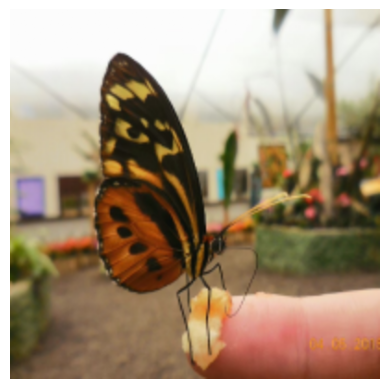

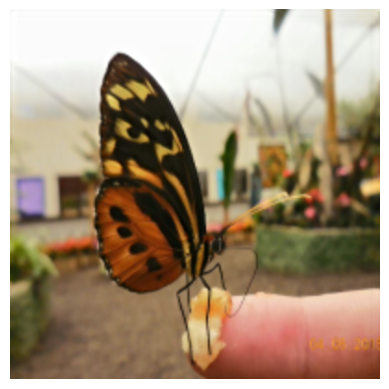

Signal to noise ratio between generated image and HR image: 33.01693353343148
Signal to noise ratio between LR image and HR image: 33.05326435896478


In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Open the image
lr_image_path = '/content/drive/MyDrive/VDSR/Train_Set/Train_LR/myButterfly.png'
lr_image = Image.open(lr_image_path)

# Define a transform to preprocess the image
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Add any other necessary preprocessing steps here
])

# Preprocess the image
input_image = transform(lr_image).unsqueeze(0)  # Add a batch dimension

# Convert the tensor back to a numpy array and transpose dimensions
input_image_np = input_image.squeeze().cpu().numpy().transpose((1, 2, 0))
# print(input_image_np.shape)
plt.imshow(input_image_np)
plt.axis('off')  # Turn off axis
plt.show()

# Pass the input through the model and clamp the output
with torch.no_grad():
    preds = model(input_image).clamp(0.0, 1.0)

# print(preds.shape)
# # Convert the output tensor to a numpy array and transpose the dimensions
output_image_np = preds.squeeze().cpu().numpy().transpose((1, 2, 0))
# print(output_image_np.shape)
plt.imshow(output_image_np)
plt.axis('off')  # Turn off axis
plt.show()

hr_image_cv = cv2.imread('/content/drive/MyDrive/VDSR/Train_Set/Train_HR/myButterfly.png')
hr_image_rgb = cv2.cvtColor(hr_image_cv, cv2.COLOR_BGR2RGB)
hr_image_rgb = hr_image_rgb.astype('float64')/255.0
print("Signal to noise ratio between generated image and HR image: " + str(psnr(hr_image_rgb, output_image_np)))
print("Signal to noise ratio between LR image and HR image: " +str(psnr(hr_image_rgb, input_image_np)))

In [ ]:
import os
from pathlib import Path
folder_path_test = '/content/drive/My Drive/VDSR/Test_Set'
Path(folder_path_test).mkdir(parents=True, exist_ok=True)

folder_path_test_lr = '/content/drive/My Drive/VDSR/Test_Set/Test_LR'
Path(folder_path_test_lr).mkdir(parents=True, exist_ok=True)

folder_path_test_hr = '/content/drive/My Drive/VDSR/Test_Set/Test_HR'
Path(folder_path_test_hr).mkdir(parents=True, exist_ok=True)

In [ ]:
path = '/content/drive/MyDrive/VDSR/Test'

for file in os.listdir(path):
  image = cv2.imread(os.path.join(path, file))
  image = cv2.resize(image, (400, 400), interpolation=cv2.INTER_LINEAR)

  # Find old and new image dimensions
  h, w, c = image.shape
  new_height = int(h / 5)
  new_width = int(w / 5)

  # Resize down the image
  resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
  resized_image = cv2.resize(resized_image, (w, h), interpolation=cv2.INTER_LINEAR)

  # cv2_imshow(image)
  # print(image.shape)
  # cv2_imshow(resized_image)
  # print("PSNR:",psnr(image, resized_image))

  save_filename = os.path.join(folder_path_test_lr, file)
  cv2.imwrite(save_filename, resized_image)

  save_filename1 = os.path.join(folder_path_test_hr, file)
  cv2.imwrite(save_filename1, image)

# EVALUATION

In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F
test_dataset = SuperResolutionDataset('/content/drive/MyDrive/VDSR/Test_Set/Test_LR','/content/drive/MyDrive/VDSR/Test_Set/Test_HR', transform=ToTensor())
test_loader = DataLoader(dataset=test_dataset,
                                  batch_size=3,
                                  shuffle=True,
                                  pin_memory=True,
                                  drop_last=True)
model.eval()
criterion = nn.MSELoss()
running_loss = 0.0
psnr_score_hr_lr = 0
psnr_score_loss = 0
total_images = 0
with torch.no_grad():

  for lr_images, hr_images in tqdm(test_loader, desc='Testing'):
        outputs = model(lr_images).clamp(0.0, 1.0)
        # Compute loss
        loss = criterion(outputs, hr_images)
        running_loss += loss.item()
        for i in range(3):
          hr_image = hr_images[i].numpy()
          hr_image = hr_image.transpose((1, 2, 0))
          lr_image = lr_images[i].numpy()
          lr_image = lr_image.transpose((1, 2, 0))
          output_image_np = outputs[i].squeeze().cpu().numpy().transpose((1, 2, 0))
          psnr_score_hr_lr = psnr(hr_image, lr_image)
          psnr_score_hr_gen = psnr(hr_image, output_image_np)
          psnr_score_loss += psnr_score_hr_gen - psnr_score_hr_lr
          total_images += 1


  print(f'Test Loss: {running_loss/len(test_loader)}')
  print(f'Average PSNR difference: {psnr_score_loss/total_images}')